In [2]:
import numpy as np
from scipy.signal import correlate2d
from skimage.io import imread
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

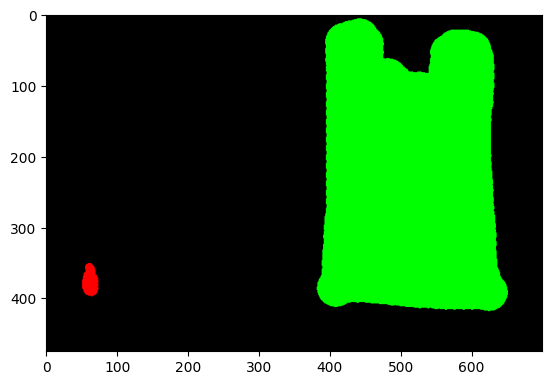

In [3]:
image_0 = imread('castle.png')
image_0_mask = imread('castle_mask.png').astype(bool)
image_1 = imread('eifel.png')
image_1_mask = imread('eifel_mask.png').astype(bool)
plt.imshow(image_0_mask.astype(float))

# Seam Display

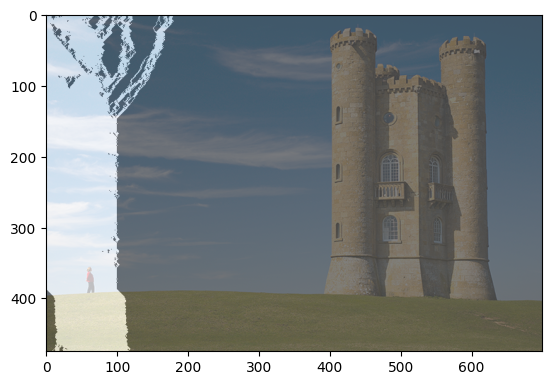

In [4]:
def energy_gradient(image):
    energy = image[:,:,0] * 0.299 + image[:,:,1] * 0.587 + image[:,:,2] * 0.114
    energy_1p_padding = np.pad(energy, ((1, 1), (1, 1)), mode='edge')
    x_grad = energy_1p_padding[1:-1, 2:] - energy_1p_padding[1:-1, :-2]
    y_grad = energy_1p_padding[2:, 1:-1] - energy_1p_padding[:-2, 1:-1]
    return np.sqrt(x_grad**2 + y_grad**2)

def number_islands(arr_sorted):
    islands = [[arr_sorted[0]]]
    for i in range(1, len(arr_sorted)):
        if arr_sorted[i]-1 == arr_sorted[i-1]:
            islands[-1].append(arr_sorted[i])
        else: islands.append([arr_sorted[i]])
    for i in range(len(islands)): islands[i] = np.array(islands[i])
    return islands

def seams(image, num_seams=10, mask_save=None, mask_remove=None, seam_direction='vertical'):

    image_ = np.array(image)
    mask_save_ = np.array(mask_save, dtype=bool)
    mask_remove_ = np.array(mask_remove, dtype=bool)
    
    if seam_direction == 'horizontal':
        image_ = np.transpose(image_, (1, 0, 2))

    energy_gradient_ = energy_gradient(image_)
    energy_gradient_[mask_save_] += image_.shape[0]*255 if mask_save_ is not None else 0
    energy_gradient_[mask_remove_] -= image_.shape[0]*255 if mask_remove_ is not None else 0
    seam_matrix_1p_padding = np.pad(energy_gradient_, ((1, 1), (1, 1)), mode='edge')

    for row in range(2, seam_matrix_1p_padding.shape[0]-1):
        seam_matrix_1p_padding[row, 1:-1] += np.min(np.vstack((
            seam_matrix_1p_padding[row-1, :-2],
            seam_matrix_1p_padding[row-1, 1:-1],
            seam_matrix_1p_padding[row-1, 2:]
        )).T, axis=1)
    seam_matrix = seam_matrix_1p_padding[1:-1, 1:-1]
    seam_mask = np.zeros(seam_matrix.shape, dtype=bool)

    for row in range(seam_matrix.shape[0]-1, -1, -1):
        if row == seam_matrix.shape[0] - 1:
            seam_mask[row, np.argpartition(seam_matrix[row,:], num_seams)[:num_seams]] = True
            continue

        mask_indices = np.array(seam_mask[row+1].nonzero()[0])
        mask_islands = number_islands(np.unique(np.clip(np.hstack((mask_indices-1, mask_indices, mask_indices+1)), 0, seam_mask.shape[1]-1)))
        mask_island_target_count = [np.isin(island, mask_indices).astype(int).sum() for island in mask_islands]

        for i in range(len(mask_islands)):
            seam_mask[row, mask_islands[i][np.argpartition(seam_matrix[row, mask_islands[i]], mask_island_target_count[i])[:mask_island_target_count[i]]]] = True
        
    if seam_direction == 'horizontal':
        seam_mask = seam_mask.T
    return seam_mask

plt.imshow(image_0, alpha=.5)
# seams(image_0, 100, None, image_0_mask[:,:,0])
plt.imshow(seams(image_0, 100, None, image_0_mask[:,:,0]), cmap='gray', alpha=.5)

# Seam Carving and Seam Extension

<Figure size 1000x2000 with 0 Axes>

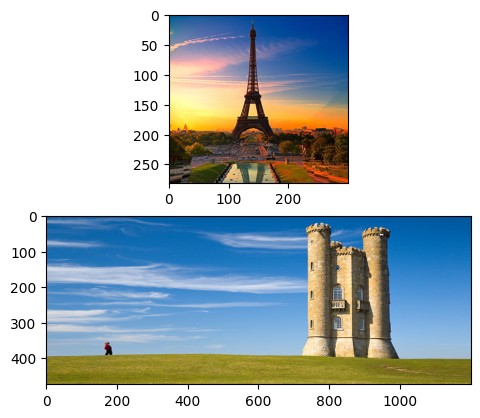

In [5]:
def seam_carve(image, num_seams=10, batch_seams=10, seam_direction='vertical', mask_save=None, mask_remove=None):
    image_ = image.copy()
    if seam_direction == 'horizontal': image_ = image_.transpose(1,0,2)

    image_ = [row for row in image_]
    mask_save_ = [row for row in mask_save] if mask_save is not None else None
    mask_remove_ = [row for row in mask_remove] if mask_remove is not None else None

    for batch in [batch_seams] * (num_seams // batch_seams) + ([num_seams % batch_seams] if num_seams % batch_seams else []):

        for i, mask in enumerate(seams(image_, batch, mask_save_, mask_remove_)):
            image_[i] = image_[i][~mask]
            if mask_save_ is not None: mask_save_[i] = mask_save_[i][~mask]
            if mask_remove_ is not None: mask_remove_[i] = mask_remove_[i][~mask]

    if seam_direction == 'horizontal': image_ = np.array(image_).transpose(1,0,2)
    return np.array(image_)


def seam_extend(image, num_seams, batch_seams=10, seam_direction='vertical', mask_save=None, mask_remove=None):
    image_ = image.copy()
    mask_save_ = mask_save.copy() if mask_save is not None else None
    mask_remove_ = mask_remove.copy() if mask_remove is not None else None

    if seam_direction == 'horizontal': 
        image_ = image_.transpose(1,0,2)
        mask_save_ = mask_save.transpose(1,0) if mask_save is not None else None
        mask_remove_ = mask_remove.transpose(1,0) if mask_remove is not None else None

    image_ = [row for row in image_]
    mask_save_ = [row for row in mask_save_] if mask_save_ is not None else None
    mask_remove_ = [row for row in mask_remove_] if mask_remove_ is not None else None
    temp_extension_mask = [np.zeros(image_[0].shape[0], dtype=bool)] * len(image_)

    for batch in [batch_seams] * (num_seams // batch_seams) + ([num_seams % batch_seams] if num_seams % batch_seams else []):

        for i, mask in enumerate(seams(image_, batch, np.array(mask_save_, dtype=bool) | np.array(temp_extension_mask, dtype=bool), mask_remove_)):
            seam_indices = mask.nonzero()[0]
            image_[i] = np.insert(image_[i], seam_indices, .5 * image_[i][seam_indices] + .5 * image_[i][np.clip(seam_indices-1, 0, mask.size-1)], axis=0)
            if mask_save_ is not None: mask_save_[i] = np.insert(mask_save_[i], seam_indices, mask_save_[i][seam_indices])
            if mask_remove_ is not None: mask_remove_[i] = np.insert(mask_remove_[i], seam_indices, mask_remove_[i][seam_indices])
            temp_extension_mask[i][seam_indices] = True
            temp_extension_mask[i] = np.insert(temp_extension_mask[i], seam_indices, True)

    if seam_direction == 'horizontal': image_ = np.array(image_).transpose(1,0,2)
    return np.array(image_)

plt.figure(figsize=(10,20))
fig, ax = plt.subplots(2)
ax[0].imshow(seam_carve(image_1, 200, batch_seams=100, seam_direction='vertical', mask_save=image_1_mask[:,:,1], mask_remove=image_1_mask[:,:,0]))
ax[1].imshow(seam_extend(image_0, 500, batch_seams=200, seam_direction='vertical', mask_save=image_0_mask[:,:,1], mask_remove=image_0_mask[:,:,0]))